In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv("sentiment_analysis_dataset.csv")

In [3]:
df.ffill(inplace=True)

In [4]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [5]:
X = df.drop(columns=['sentiment'])
y = df['sentiment']

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(random_state=42)
svm_model = SVC(probability=True, random_state=42)

In [9]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

In [10]:
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [11]:
dt_predictions = dt_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)


In [12]:
def evaluate_model(model_name, y_test, predictions):
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, predictions))
    print(f"Accuracy: {accuracy_score(y_test, predictions):.2f}\n")

    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       106
           1       0.72      0.69      0.71        94

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200

Accuracy: 0.73



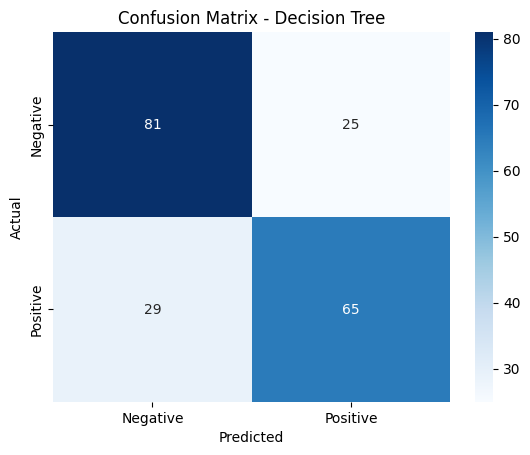

In [13]:
evaluate_model("Decision Tree", y_test, dt_predictions)


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       106
           1       0.83      0.90      0.87        94

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200

Accuracy: 0.87



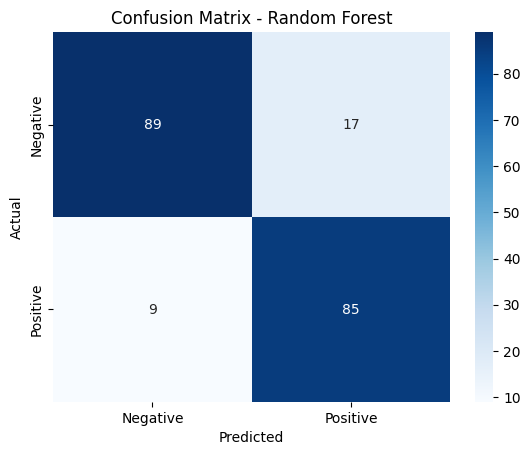

In [14]:
evaluate_model("Random Forest", y_test, rf_predictions)


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       106
           1       0.63      0.73      0.68        94

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.67       200

Accuracy: 0.68



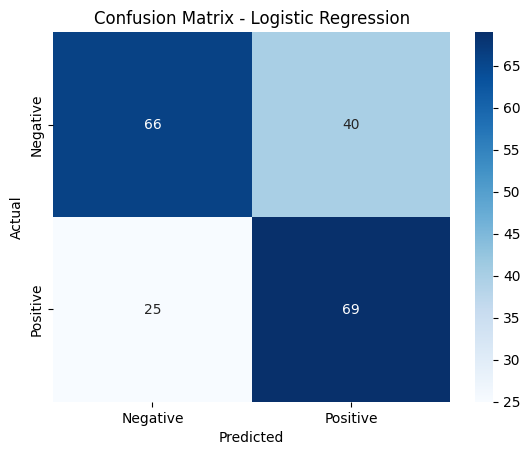

In [15]:
evaluate_model("Logistic Regression", y_test, lr_predictions)


Support Vector Machine Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       106
           1       0.89      0.96      0.92        94

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.93       200

Accuracy: 0.93



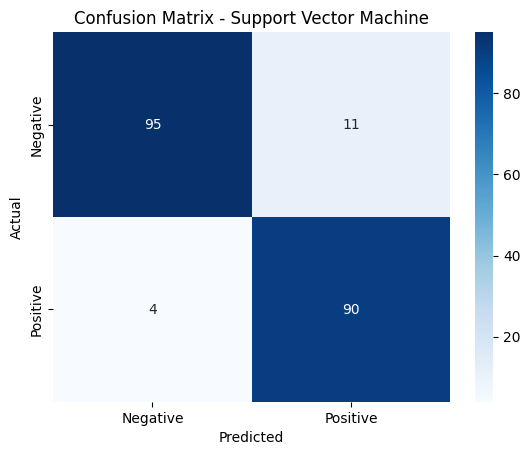

In [16]:
evaluate_model("Support Vector Machine", y_test, svm_predictions)

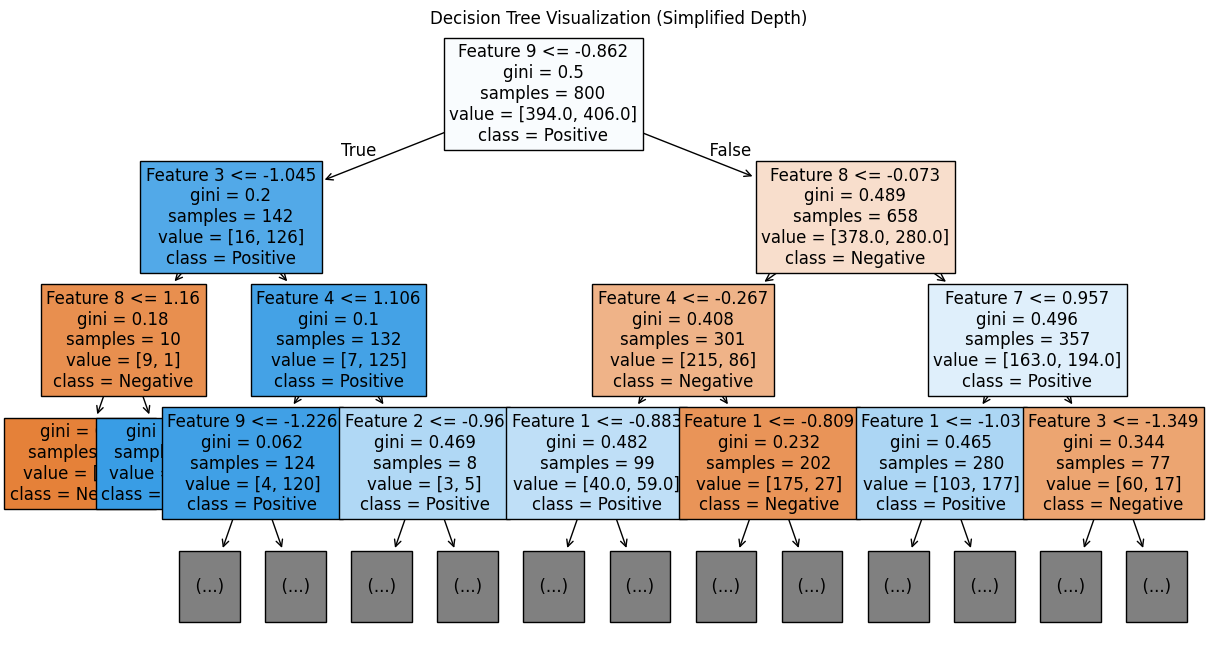

In [17]:
from sklearn.tree import plot_tree

# Define feature names and class names
feature_names = [
    "Feature 1", "Feature 2", "Feature 3", "Feature 4", 
    "Feature 5", "Feature 6", "Feature 7", "Feature 8", 
    "Feature 9", "Feature 10"
]
class_names = ["Negative", "Positive"]

# Restrict the tree depth for visualization
plt.figure(figsize=(15, 8))
plot_tree(dt_model, max_depth=3, filled=True, fontsize=12, 
          feature_names=feature_names, class_names=class_names)
plt.title("Decision Tree Visualization (Simplified Depth)")
plt.show()


In [18]:
rf_importances = pd.Series(rf_model.feature_importances_, index=df.drop(columns=['sentiment']).columns).sort_values(ascending=False)

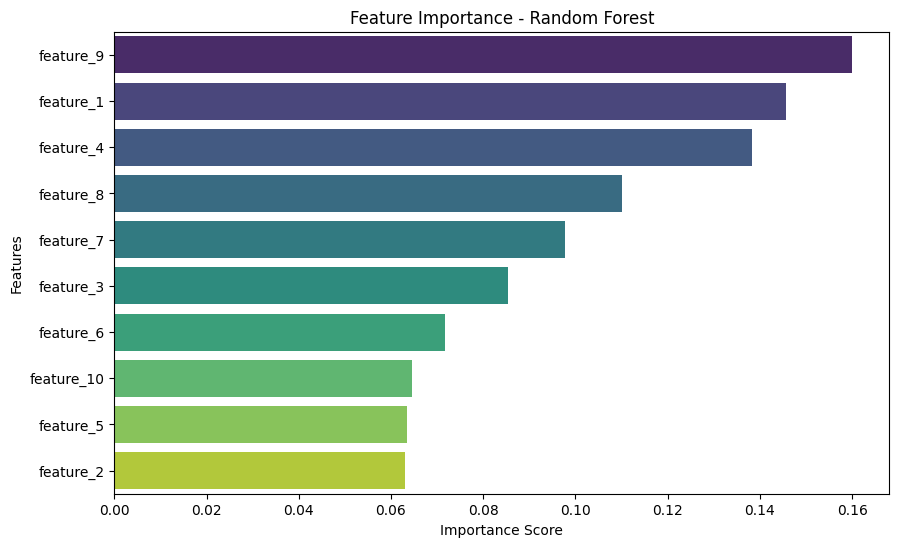

In [19]:
rf_importances_df = rf_importances.reset_index()
rf_importances_df.columns = ["Feature", "Importance"]

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importances_df, x="Importance", y="Feature", hue="Feature", dodge=False, palette='viridis', legend=False)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

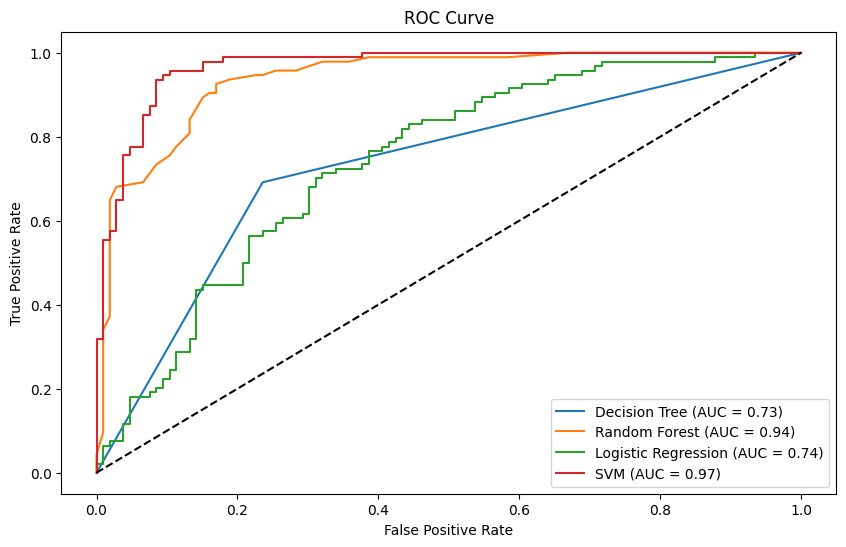

In [20]:
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        y_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc_score = roc_auc_score(y_test, y_probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
models = {
    "Decision Tree": dt_model,    
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "SVM": svm_model
}
plot_roc_curve(models, X_test, y_test)

In [21]:
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

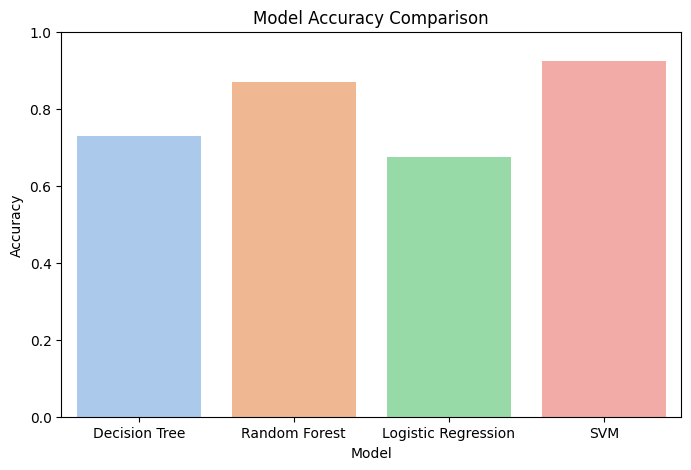

In [22]:
accuracies = {
    "Decision Tree": accuracy_score(y_test, dt_predictions),
    "Random Forest": accuracy_score(y_test, rf_predictions),
    "Logistic Regression": accuracy_score(y_test, lr_predictions),
    "SVM": accuracy_score(y_test, svm_predictions)
}

accuracy_df = pd.DataFrame({
    "Model": list(accuracies.keys()),
    "Accuracy": list(accuracies.values())
})

plt.figure(figsize=(8, 5))
sns.barplot(data=accuracy_df, x="Model", y="Accuracy", hue="Model", dodge=False, palette='pastel', legend=False)
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()


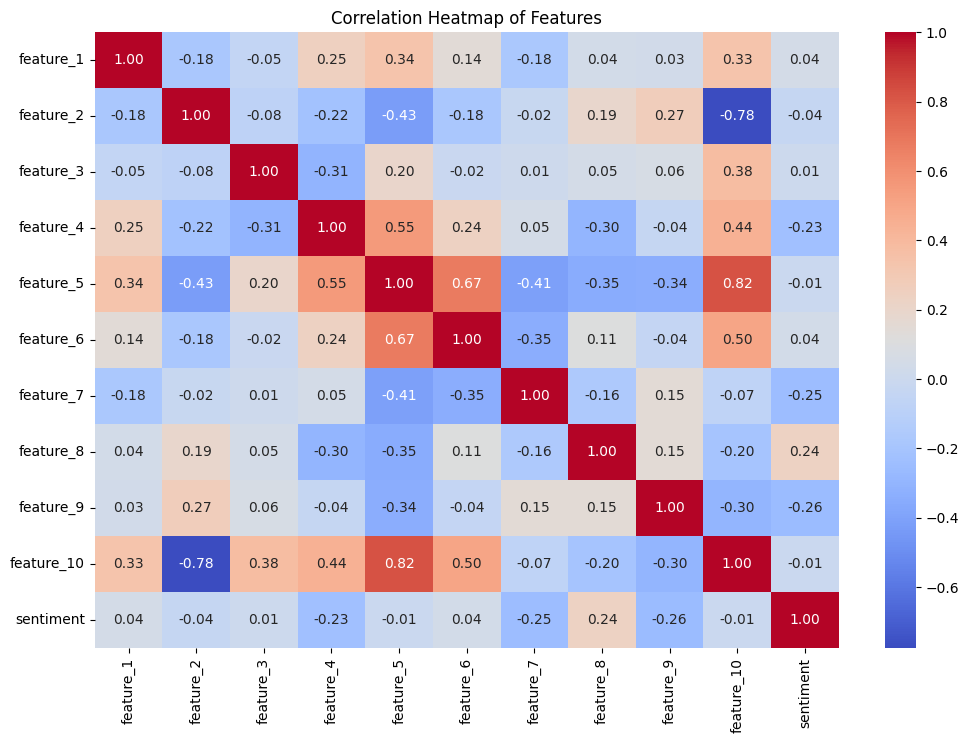

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()


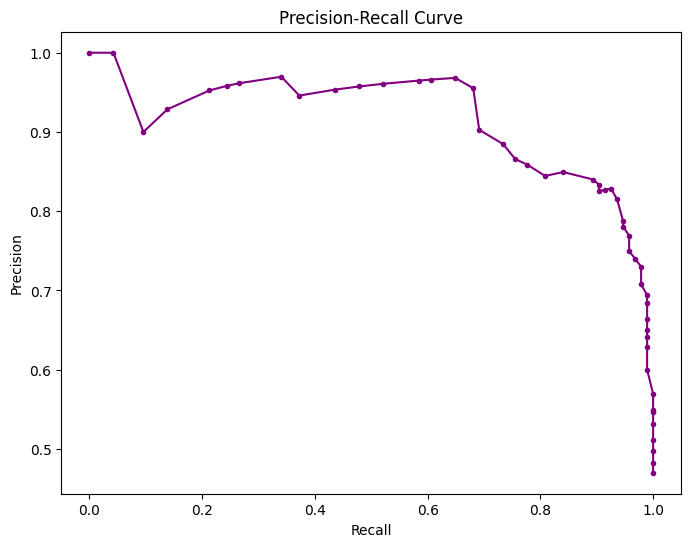

In [24]:
from sklearn.metrics import precision_recall_curve

y_probs = rf_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='purple')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


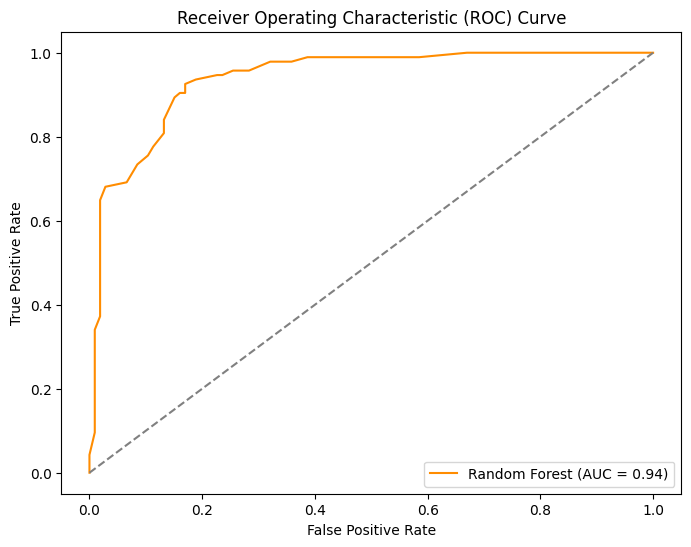

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

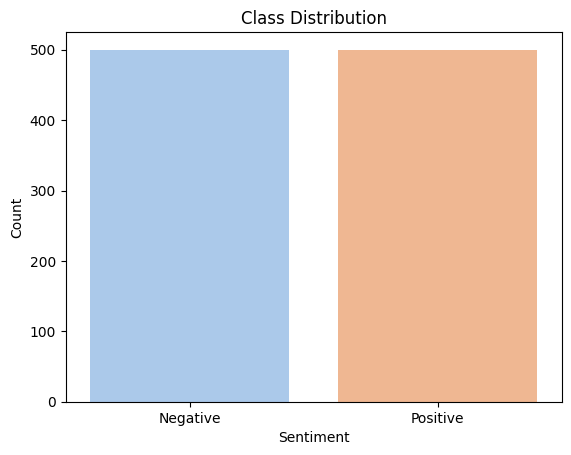

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="sentiment", hue="sentiment", palette="pastel", legend=False)
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()
